## Modeling

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_cleaning.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Modeling (this notebook)

**In this notebook, you'll find:**
- Regression modeling to predict life expectancy
- Classification modeling to predict the assigned life expectancy category

In [1]:
# Imports

import pandas as pd
import numpy as np

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier, BaggingRegressor, BaggingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, r2_score

To ensure that we're analyzing our data as thoroughly as possible, we'd like to model both with and without our engineered features. This will allow us to better measure the efficacy, if any, of our additional metrics.

To streamline the process, we'll be reading in the dataframe without the extra features and, separately, the dataframe that does include them.

In [2]:
non_feat_eng_gap = pd.read_csv('../data/aggregated_df_cleaned.csv')

# Dropping ID because it would be repetitive to use with the geo column in modeling
non_feat_eng_gap.drop(columns='id', inplace=True)

non_feat_eng_gap.head()

,geo,year,income_per_person,population,life_expectancy,region,sub-region
0,Afghanistan,1800,603,3280000,28.2,Asia,Southern Asia
1,Afghanistan,1801,603,3280000,28.2,Asia,Southern Asia
2,Afghanistan,1802,603,3280000,28.2,Asia,Southern Asia
3,Afghanistan,1803,603,3280000,28.2,Asia,Southern Asia
4,Afghanistan,1804,603,3280000,28.2,Asia,Southern Asia


In [3]:
gap = pd.read_csv('../data/gap_features_engineered.csv')
gap.drop(columns='id', inplace=True)

gap.head()

,geo,year,income_per_person,population,life_expectancy,region,sub-region,income_per_person_low_q,income_per_person_high_q,income_per_person_category,population_low_q,population_high_q,population_category,life_expectancy_low_q,life_expectancy_high_q,life_expectancy_category
0,Afghanistan,1800,603,3280000,28.2,Asia,Southern Asia,575.0,1230.0,average,121000.0,3030000.0,high,28.8,35.1,low
1,Afghanistan,1801,603,3280000,28.2,Asia,Southern Asia,575.0,1230.0,average,121000.0,3050000.0,high,28.7,35.2,low
2,Afghanistan,1802,603,3280000,28.2,Asia,Southern Asia,574.0,1230.0,average,121000.0,3060000.0,high,28.7,35.1,low
3,Afghanistan,1803,603,3280000,28.2,Asia,Southern Asia,574.0,1230.0,average,121000.0,3070000.0,high,28.7,35.0,low
4,Afghanistan,1804,603,3280000,28.2,Asia,Southern Asia,573.0,1230.0,average,121000.0,3080000.0,high,28.7,35.0,low


---
### Establishing the Regression Baseline

In [4]:
gap['life_expectancy'].mean()

43.20531068920399

In [5]:
X = gap.drop(columns='life_expectancy')
y = gap['life_expectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

reg_baseline = gap['life_expectancy'].mean()
baseline_model = [reg_baseline] * len(y_test)

baseline_r2 = r2_score(y_test, baseline_model)
baseline_rmse = np.sqrt(metrics.mean_squared_error(y_test, baseline_model))

print(f"The baseline model R\u00b2 score is {round(baseline_r2, 6)}")
print(f"The baseline model RMSE is {round(baseline_rmse, 6)}")

The baseline model R² score is -0.000105
The baseline model RMSE is 16.326366


- Using the mean of our target variable as the prediction for all test observations, we've achieved an R<sup>2</sup> score of just below zero.
- This tells us that our baseline model does not predict life expectancy very well, and is about 16 years off of the true value, on average.
- This score will act as the benchmark for our regression models and aids in evaluating the predictive power of our features.

---

### Regression Modeling Function

All scores, features, and feature counts will be added to this dataframe to aid in the evaluation of each of our models.

In [6]:
reg_models_eval = pd.DataFrame(columns=['model_used', 'train_score', 'test_score', 'rmse', 'features_used', 'num_features'])

In [7]:
def reg_model(model, model_X, model_y, model_id, fe):
    X = model_X
    y = model_y
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

    sc = MinMaxScaler()
    X_sc_train = sc.fit_transform(X_train)
    X_sc_test = sc.transform(X_test)

    model.fit(X_sc_train, y_train)
    preds = model.predict(X_sc_test)

    train_score = model.score(X_sc_train, y_train)
    test_score = model.score(X_sc_test, y_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))

    feats_used = list(model_X.columns)
    num_feats = len(feats_used)

    if fe == False:
        fe = 'Non-FE '
    else:
        fe = ''
    model_id = fe + model_id
    
    model_list = [model_id, train_score, test_score, rmse, feats_used, num_feats]
    reg_models_eval.loc[len(reg_models_eval.index)] = model_list
    
    print(f'{model_id} train score: {train_score}')
    print(f'{model_id} test score: {test_score}')
    print(f'{model_id} RMSE: {rmse}')

---

### Regression Models to Predict Life Expectancy

#### Non-Feature Engineered Dataset Models

To start, we'll be using population, income per person, year, and the region/sub-region to predict life expectancy. We'll then add in the geo column and compare the test scores.

In [8]:
non_fe_gap_dummy = pd.get_dummies(non_feat_eng_gap, columns = ['region', 'sub-region'])

In [9]:
X = non_fe_gap_dummy.drop(columns = ['geo', 'life_expectancy'])
y = non_fe_gap_dummy['life_expectancy']
lr = LinearRegression()

In [10]:
reg_model(lr, X, y, 'LinReg No Geo', False)

Non-FE LinReg No Geo train score: 0.7666419909073534
Non-FE LinReg No Geo test score: 0.7612591131203961
Non-FE LinReg No Geo RMSE: 7.976824460037845


Now with geo added back in to be dummified.

In [11]:
non_fe_gap_dummy = pd.get_dummies(non_feat_eng_gap)

In [12]:
X = non_fe_gap_dummy.drop(columns = 'life_expectancy')
y = non_fe_gap_dummy['life_expectancy']
lr = LinearRegression()

In [13]:
reg_model(lr, X, y, 'LinReg All Cols', False)

Non-FE LinReg All Cols train score: 0.7990639434458796
Non-FE LinReg All Cols test score: 0.7906222500300919
Non-FE LinReg All Cols RMSE: 7.470194296269743


- We can see that including the 'geo' column in our non-feature engineered model produced slightly higher scores than when the column was excluded. Unfortunately, these scores still fall below our target 0.85 threshold.

We're now going to run a few more model trials to test the effects of certain features before we begin trials with our feature-engineered dataframe.
To maintain consistency, we'll proceed with using Linear Regression only until we identify our optimal list of features to include.

Dropping all region columns next.

In [14]:
X = non_fe_gap_dummy.drop(columns = [col for col in non_fe_gap_dummy.columns if 'region' in col] + ['life_expectancy'])
y = non_fe_gap_dummy['life_expectancy']
lr = LinearRegression()

In [15]:
reg_model(lr, X, y, 'LinReg No Region', False)

Non-FE LinReg No Region train score: 0.799073251296393
Non-FE LinReg No Region test score: 0.7905904856706578
Non-FE LinReg No Region RMSE: 7.470760920320818


- Removing all region and sub-region columns does not appear to have had a meaningful effect on the model. Both the train and test scores remained nearly the same.

Now removing the population column.

In [16]:
X = non_fe_gap_dummy.drop(columns = ['population', 'life_expectancy'])
y = non_fe_gap_dummy['life_expectancy']
lr = LinearRegression()

In [17]:
reg_model(lr, X, y, 'LinReg No Pop', False)

Non-FE LinReg No Pop train score: 0.7957576875172134
Non-FE LinReg No Pop test score: 0.7868977400344243
Non-FE LinReg No Pop RMSE: 7.536343088142505


- This produced marginally lower train and test scores than our all-columns model. As mentioned in our EDA conclusion, population does not seem to be strongly correlated with life expectancy, so predictably would not be critically important in modeling.

And finally, with our income per person feature removed.

In [18]:
X = non_fe_gap_dummy.drop(columns = ['income_per_person', 'life_expectancy'])
y = non_fe_gap_dummy['life_expectancy']
lr = LinearRegression()

In [19]:
reg_model(lr, X, y, 'LinReg No Income', False)

Non-FE LinReg No Income train score: 0.7664089513254762
Non-FE LinReg No Income test score: 0.7587974215631085
Non-FE LinReg No Income RMSE: 8.017844082476223


- These are the lowest scores we've seen so far. With a noticeable drop in both train and test scores, this indicates to us that income per person should definitely be used as a feature in our models.

In [20]:
reg_models_eval

,model_used,train_score,test_score,rmse,features_used,num_features
0,Non-FE LinReg No Geo,0.766642,0.761259,7.976824,"[year, income_per_person, population, region_A...",25
1,Non-FE LinReg All Cols,0.799064,0.790622,7.470194,"[year, income_per_person, population, geo_Afgh...",196
2,Non-FE LinReg No Region,0.799073,0.790590,7.470761,"[year, income_per_person, population, geo_Afgh...",174
3,Non-FE LinReg No Pop,0.795758,0.786898,7.536343,"[year, income_per_person, geo_Afghanistan, geo...",195
4,Non-FE LinReg No Income,0.766409,0.758797,8.017844,"[year, population, geo_Afghanistan, geo_Albani...",195


- Although our model that used all columns scored similarly to the model that did not use any regional features, the all-columns model achieved a minimally lower RMSE. For this reason, we'll begin model trials on our feature-engineered dataset using all columns.

---

#### Feature Engineered Dataset Models

In [21]:
gap_dummy = pd.get_dummies(gap)

Because we have our original life expectancy column, as well as several engineered features that measure the relative life expectancy values, we'll be removing all of these from our model so as to preserve the integrity of our scores.

In [22]:
life_exp_cols = [i for i in gap_dummy.columns if i.startswith('life_exp')]

In [23]:
X = gap_dummy.drop(columns=life_exp_cols)
y = gap_dummy['life_expectancy']
lr = LinearRegression()

In [24]:
reg_model(lr, X, y, 'LinReg All Columns', True)

LinReg All Columns train score: 0.8860362865112813
LinReg All Columns test score: 0.8804509295882247
LinReg All Columns RMSE: 5.644685312155123


- Our added features boosted the train and test scores by almost 10%.

Because our all-columns model scored the best on the non-engineered dataframe, and the scores improved even further when all features were used on the engineered dataset, we feel confident proceeding with our all-features X and y for these model trials.

We are going to alter our regression function parameters to account for the now-consistent X and y values.

In [25]:
def reg_model(model, model_id):
    X = gap_dummy.drop(columns=life_exp_cols)
    y = gap_dummy['life_expectancy']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

    sc = MinMaxScaler()
    X_sc_train = sc.fit_transform(X_train)
    X_sc_test = sc.transform(X_test)

    model.fit(X_sc_train, y_train)
    preds = model.predict(X_sc_test)

    train_score = model.score(X_sc_train, y_train)
    test_score = model.score(X_sc_test, y_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))

    feats_used = list(X.columns)
    num_feats = len(feats_used)
    
    model_list = [model_id, train_score, test_score, rmse, feats_used, num_feats]
    reg_models_eval.loc[len(reg_models_eval.index)] = model_list
    
    print(f'{model_id} train score: {train_score}')
    print(f'{model_id} test score: {test_score}')
    print(f'{model_id} RMSE: {rmse}')

##### Decision Tree Regressor

In [26]:
dtree_reg = DecisionTreeRegressor(random_state=42)

reg_model(dtree_reg, 'Decision Tree Regressor')

Decision Tree Regressor train score: 1.0
Decision Tree Regressor test score: 0.983588480717782
Decision Tree Regressor RMSE: 2.0914188943304812


- While clearly overfit, these are our best scores so far.
- We may need to incorporate bagging into our model to reduce variance.

##### Random Forest Regressor

In [27]:
rf_reg = RandomForestRegressor(random_state=42)

reg_model(rf_reg, 'Random Forest Regressor')

Random Forest Regressor train score: 0.9987023921659202
Random Forest Regressor test score: 0.990014590040028
Random Forest Regressor RMSE: 1.6313591512304464


- We are slightly overfit here as well, but less so than our Decision Tree Model. 
- This may be in part due to the random samples of data used in Random Forest models to prevent overfitting.

##### Bagging Regressor

In [28]:
bag_reg = BaggingRegressor(random_state=42)

reg_model(bag_reg, 'Bagging Regressor')

Bagging Regressor train score: 0.9980832752974917
Bagging Regressor test score: 0.9895070540225109
Bagging Regressor RMSE: 1.6723044753105687


- The Bagging model did, in fact, reduce the variance, though not more than the Random Forest model above. 
- These are two very high-performing regressors that could both be used as our final production model.

##### Gradient Boosting Regressor

In [29]:
gboost_reg = GradientBoostingRegressor(random_state=42)

reg_model(gboost_reg, 'Gradient Boosting Regressor')

Gradient Boosting Regressor train score: 0.9483113814289806
Gradient Boosting Regressor test score: 0.9438234680853457
Gradient Boosting Regressor RMSE: 3.8694041730135464


- While these scores are lower than the Random Forest and Bagging models, the Gradient Boost model is the least overfit so far. 

##### Ada Boost Regressor

In [30]:
ada_boost_reg = AdaBoostRegressor(random_state=42)

reg_model(ada_boost_reg, 'Ada Boost Regressor')

Ada Boost Regressor train score: 0.8139238514444936
Ada Boost Regressor test score: 0.8109009334160835
Ada Boost Regressor RMSE: 7.099231299110578


- The AdaBoost model did not perform as well as we'd expected it to, and the scores were less than our benchmark Linear Regression model.
- Though above our benchmark, we likely will not move forward with AdaBoost as our production model.

##### KNN Regressor

In [31]:
knn_reg = KNeighborsRegressor()

reg_model(knn_reg, 'KNN Regressor')

KNN Regressor train score: 0.9907314563075328
KNN Regressor test score: 0.9842869677354665
KNN Regressor RMSE: 2.0464287789732674


- The KNN model scored higher than we'd thought it would! 
- The difference in train and test scores is greater than that of the Gradient Boost model, but less than those of our Random Forest and Bagging models.

In [49]:
reg_models_eval.sort_values(by='rmse')

,model_used,train_score,test_score,rmse,features_used,num_features,overfitness
7,Random Forest Regressor,0.998702,0.990015,1.631359,"[year, income_per_person, population, income_p...",206,0.008688
8,Bagging Regressor,0.998083,0.989507,1.672304,"[year, income_per_person, population, income_p...",206,0.008576
11,KNN Regressor,0.990731,0.984287,2.046429,"[year, income_per_person, population, income_p...",206,0.006444
6,Decision Tree Regressor,1.000000,0.983588,2.091419,"[year, income_per_person, population, income_p...",206,0.016412
9,Gradient Boosting Regressor,0.948311,0.943823,3.869404,"[year, income_per_person, population, income_p...",206,0.004488
5,LinReg All Columns,0.886036,0.880451,5.644685,"[year, income_per_person, population, income_p...",206,0.005585
10,Ada Boost Regressor,0.813924,0.810901,7.099231,"[year, income_per_person, population, income_p...",206,0.003023
1,Non-FE LinReg All Cols,0.799064,0.790622,7.470194,"[year, income_per_person, population, geo_Afgh...",196,0.008442
2,Non-FE LinReg No Region,0.799073,0.790590,7.470761,"[year, income_per_person, population, geo_Afgh...",174,0.008483
3,Non-FE LinReg No Pop,0.795758,0.786898,7.536343,"[year, income_per_person, geo_Afghanistan, geo...",195,0.008860


- From the above, we can see that even our best non-FE model did not score as well as our worst all-features model (Ada Boost).
- The RMSE metrics appear to follow the same pattern as our test scores, with the Random Forest, Bagging, and KNN models outperforming all others.

Although we do want to move forward with one of our top-performing models, we also would like to minimize bias and proceed with a model that will score the best on unseen data in future trials.

In [33]:
reg_models_eval['overfitness'] = reg_models_eval['train_score'] - reg_models_eval['test_score']
reg_models_eval.sort_values(by='overfitness')

,model_used,train_score,test_score,rmse,features_used,num_features,overfitness
10,Ada Boost Regressor,0.813924,0.810901,7.099231,"[year, income_per_person, population, income_p...",206,0.003023
9,Gradient Boosting Regressor,0.948311,0.943823,3.869404,"[year, income_per_person, population, income_p...",206,0.004488
0,Non-FE LinReg No Geo,0.766642,0.761259,7.976824,"[year, income_per_person, population, region_A...",25,0.005383
5,LinReg All Columns,0.886036,0.880451,5.644685,"[year, income_per_person, population, income_p...",206,0.005585
11,KNN Regressor,0.990731,0.984287,2.046429,"[year, income_per_person, population, income_p...",206,0.006444
4,Non-FE LinReg No Income,0.766409,0.758797,8.017844,"[year, population, geo_Afghanistan, geo_Albani...",195,0.007612
1,Non-FE LinReg All Cols,0.799064,0.790622,7.470194,"[year, income_per_person, population, geo_Afgh...",196,0.008442
2,Non-FE LinReg No Region,0.799073,0.790590,7.470761,"[year, income_per_person, population, geo_Afgh...",174,0.008483
8,Bagging Regressor,0.998083,0.989507,1.672304,"[year, income_per_person, population, income_p...",206,0.008576
7,Random Forest Regressor,0.998702,0.990015,1.631359,"[year, income_per_person, population, income_p...",206,0.008688


#### Regression Model Conclusions

Overall, we've determined that using our engineered features substantially improved model performance and reduced the models' RMSE. Six of our 12 models met the target R<sup>2</sup> score of 0.85, and just five were under the maximum RMSE threshold of 5.

If we were selecting a production model based on RMSE alone, Random Forest is the clear champion with our Bagging Regressor following closely behind. However, we are also taking our models' variance into account, as we cannot proceed with any model that is overfit on the training set and will perform poorly on unseen data. 

With this in mind, our final model would likely be either KNN, which achieved an RMSE of 2.05, and train/test R<sup>2</sup> scores of .991 and .984, respectively, or our Gradient Boost model that produced a moderately higher RMSE of 3.87, but also had two of the closest train/test R<sup>2</sup> scores of .948 and .944, respectively.


---

### Classification Models to Predict Life Expectancy Category

We'll now be moving into predicting a country's life expectancy category. Based on our data, we're expecting accuracy scores in the high 80s to low 90s. In addition to calculating an array of classification metrics, our function will return multi-class confusion matrices for each model, which will help us visualize where they may be struggling to classify. 

We'll be keeping our X values the same and will again remove any columns that are associated with our target variable - in this case, life expectancy category. Accuracy is our key performance indicator, though we will be looking at our other metrics such as F1 score, precision, recall, and specificity.

---

### Establishing the Classification Baseline

In [34]:
cols_to_dummy = [x for x in gap.select_dtypes('object').columns if x != 'life_expectancy_category']

gap_class_dummy = pd.get_dummies(gap, columns=cols_to_dummy)
gap_class_dummy.drop(columns=[col for col in gap_class_dummy if col.startswith('life_exp') and col != 'life_expectancy_category'], inplace=True)

In [35]:
gap_class_dummy['life_expectancy_category'].value_counts(normalize=True)

average    0.583060
low        0.210713
high       0.206227
Name: life_expectancy_category, dtype: float64

- Based on the distribution of our target variable, we could reasonably expect about 60% accuracy if we predicted the most frequent class every time.

---

### Classification Modeling Function

In [36]:
class_models_eval = pd.DataFrame(columns=['model_used', 'train_score', 'test_score',
'accuracy', 'f1_score', 'precision', 'recall', 'specificity'])

In [37]:
def class_model(model, model_id):

    '''Defining X and y'''
    X = gap_class_dummy.drop(columns='life_expectancy_category')
    y = gap_class_dummy['life_expectancy_category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

    sc = MinMaxScaler()
    X_sc_train = sc.fit_transform(X_train)
    X_sc_test = sc.transform(X_test)

    model.fit(X_sc_train, y_train)
    train_score = model.score(X_sc_train, y_train)
    test_score = model.score(X_sc_test, y_test)

    '''Calculating accuracy and misclassification rates'''
    preds = model.predict(X_sc_test)
    tn, fp, fn, tp, tn, fp, fn, tp, tn, fp, fn, tp = multilabel_confusion_matrix(y_test, preds, labels=['average', 'high', 'low']).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    misclass = 1 - acc
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all metrics to our model evaluation dataframe'''
    model_list = [model_id, train_score, test_score, acc, f1, prec, recall, spec]
    class_models_eval.loc[len(class_models_eval.index)] = model_list

    '''Output will show all scores'''
    print(f'{model_id} Training Score: {round(train_score, 5)}')
    print(f'{model_id} Testing Score: {round(test_score, 5)} \n')
    print(f'Accuracy Rate: {round(acc, 5)}')
    print(f'Misclassification Rate: {round(misclass, 5)}')
    print(f'Specificity Rate: {round(spec, 5)}')
    print(f'Precision Rate: {round(prec, 5)}')
    print(f'Recall Rate: {round(recall, 5)}')
    print(f'F1 Score: {round(f1, 5)}')

    '''Returning a confusion matrix for each model'''
    print(f'{model_id} confusion matrix:')
    return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='YlGnBu', values_format='d');

---

### Classification Models to Predict Life Expectancy Category

##### Logistic Regression

Logistic Regression Training Score: 0.80421
Logistic Regression Testing Score: 0.79974 

Accuracy Rate: 0.87568
Misclassification Rate: 0.12432
Specificity Rate: 0.92905
Precision Rate: 0.71123
Recall Rate: 0.6708
F1 Score: 0.69043
Logistic Regression confusion matrix:


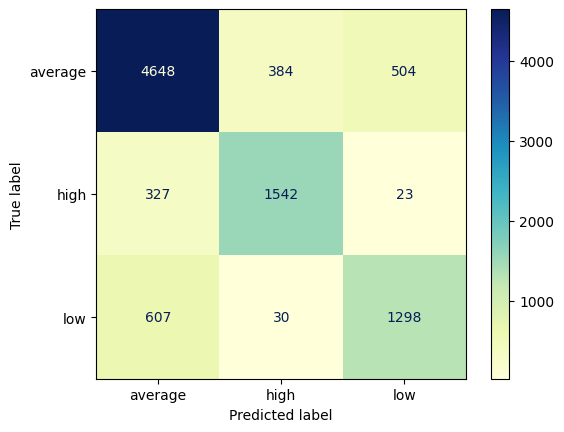

In [38]:
logreg = LogisticRegression(max_iter=10_000, random_state=42)

class_model(logreg, 'Logistic Regression')

- The Logistic Regression model performed decently well and saw a 0.876 accuracy score. 
- It appears that this model struggles to differentiate between countries labeled as 'average' and those ranked as 'low' in terms of life expectancy category.
- We'd predict that this is where most of our other models will falter, as well.
- There also seems to be some trouble in discerning between 'average' and 'high' labeled countries. We'll make a note to pay attention to this in our upcoming models, as it could indicate a blind spot in our models/function.

##### Decision Tree Classifier

Decision Tree Classifier Training Score: 1.0
Decision Tree Classifier Testing Score: 0.95867 

Accuracy Rate: 0.97458
Misclassification Rate: 0.02542
Specificity Rate: 0.98546
Precision Rate: 0.94354
Recall Rate: 0.93282
F1 Score: 0.93815
Decision Tree Classifier confusion matrix:


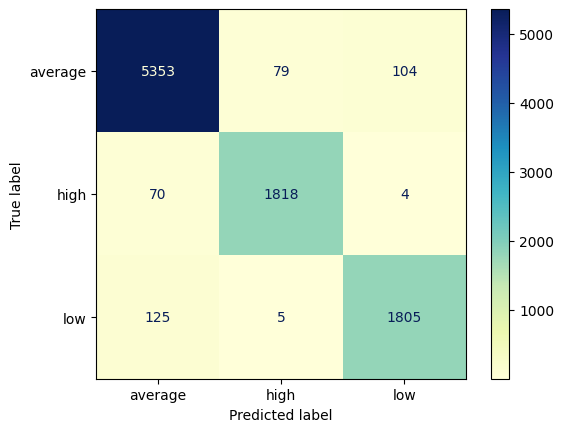

In [39]:
dtree_class = DecisionTreeClassifier(random_state=42)

class_model(dtree_class, 'Decision Tree Classifier')

- While definitely overfit, the Decision Tree model scored about 10% higher in accuracy.
- We still see a similar pattern of mistaking 'low' for 'average' and vice versa, but our classifier was clearly more adept at separating the two than our Logistic Regression model.

##### Random Forest Classifier

Random Forest Classifier Training Score: 1.0
Random Forest Classifier Testing Score: 0.96443 

Accuracy Rate: 0.97832
Misclassification Rate: 0.02168
Specificity Rate: 0.99085
Precision Rate: 0.9636
Recall Rate: 0.93023
F1 Score: 0.94662
Random Forest Classifier confusion matrix:


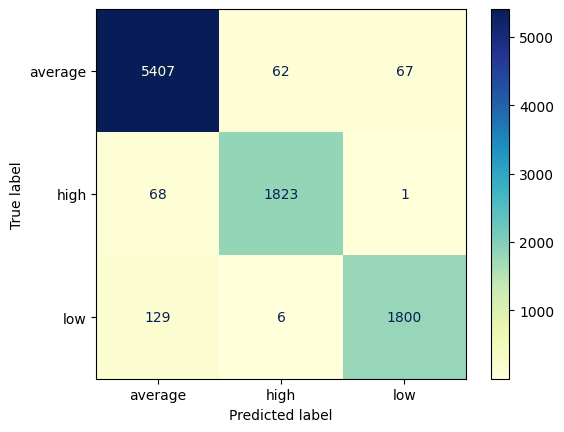

In [40]:
rf_class = RandomForestClassifier(random_state=42)

class_model(rf_class, 'Random Forest Classifier')

- Similar to our regression trials, Random Forest again scored very high on both the train and test datasets. This model is also overfit.
- The 0.978 accuracy score is greater than the Decision Tree model by a slim margin of about 0.004.
- This model also ran into some difficulty classifying the low and average countries, but significantly reduced the number of 'average' countries predicted as 'low' compared to the two previous models.

##### Bagging Classifier

Bagging Classifier Training Score: 0.9969
Bagging Classifier Testing Score: 0.96369 

Accuracy Rate: 0.97811
Misclassification Rate: 0.02189
Specificity Rate: 0.99058
Precision Rate: 0.96257
Recall Rate: 0.93023
F1 Score: 0.94612
Bagging Classifier confusion matrix:


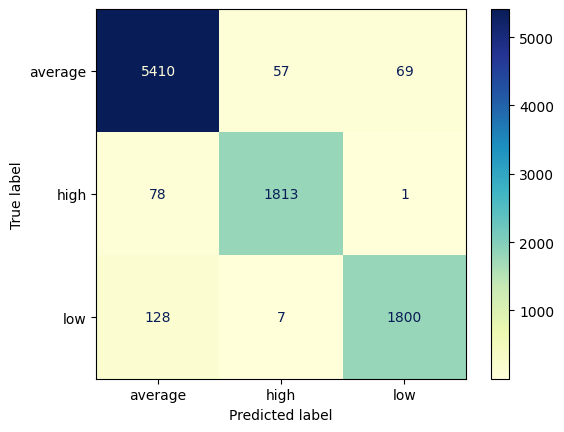

In [41]:
bag_class = BaggingClassifier(random_state=42)

class_model(bag_class, 'Bagging Classifier')

- The Bagging model classified very similarly to our Random Forest model, with a few adjustments that led to seven additional mislabeled predictions and a negligible decrease in accuracy by 0.000214.
- We see less variance here than in the previous two models, but there is still slight overfitness in our train/test scores.

##### Gradient Boosting Classifier

Gradient Boosting Classifier Training Score: 0.88094
Gradient Boosting Classifier Testing Score: 0.87643 

Accuracy Rate: 0.93101
Misclassification Rate: 0.06899
Specificity Rate: 0.98815
Precision Rate: 0.93993
Recall Rate: 0.71163
F1 Score: 0.81
Gradient Boosting Classifier confusion matrix:


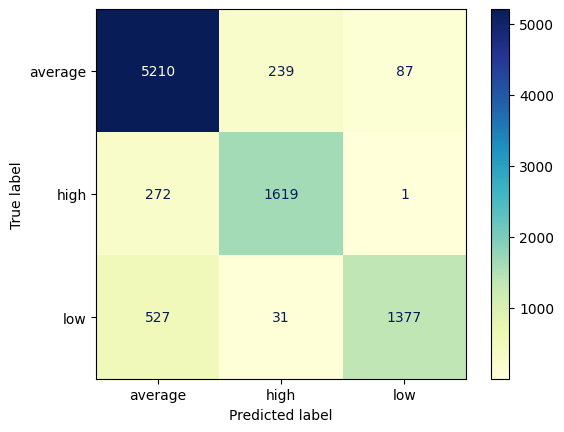

In [42]:
gboost_class = GradientBoostingClassifier(random_state=42)

class_model(gboost_class, 'Gradient Boosting Classifier')

- The Gradient Boosting model did not perform as well as we'd expected it to.
- The most common misclassification was the swapping of 'low' for 'average', which is true of our other models, as well.
- However, this model also saw a large uptick in 'average'/'high' mistakes, leading to a drop in recall rate.
- This is the least overfit model we've seen so far.

##### Ada Boost Classifier

Ada Boost Classifier Training Score: 0.70334
Ada Boost Classifier Testing Score: 0.71099 

Accuracy Rate: 0.81683
Misclassification Rate: 0.18317
Specificity Rate: 0.93376
Precision Rate: 0.59136
Recall Rate: 0.36796
F1 Score: 0.45365
Ada Boost Classifier confusion matrix:


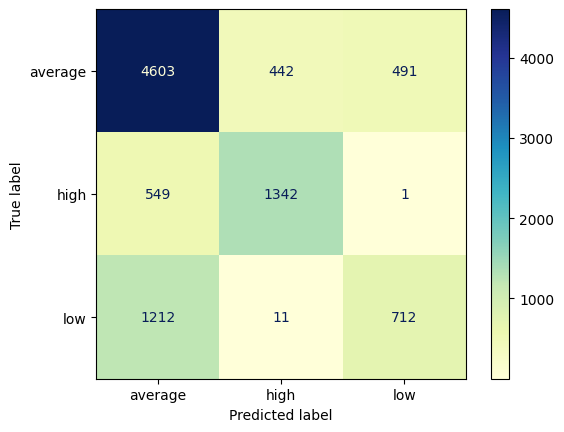

In [43]:
adaboost_class = AdaBoostClassifier(random_state=42)

class_model(adaboost_class, 'Ada Boost Classifier')

- Though we were optimistic, our Ada Boost model did not perform well.
- It did alright on specificity, but all other metrics decreased significantly, including accuracy, precision, recall, and train/test scores.

##### KNN Classifier

KNN Classifier Training Score: 0.97714
KNN Classifier Testing Score: 0.95856 

Accuracy Rate: 0.9749
Misclassification Rate: 0.0251
Specificity Rate: 0.9856
Precision Rate: 0.9441
Recall Rate: 0.93385
F1 Score: 0.93895
KNN Classifier confusion matrix:


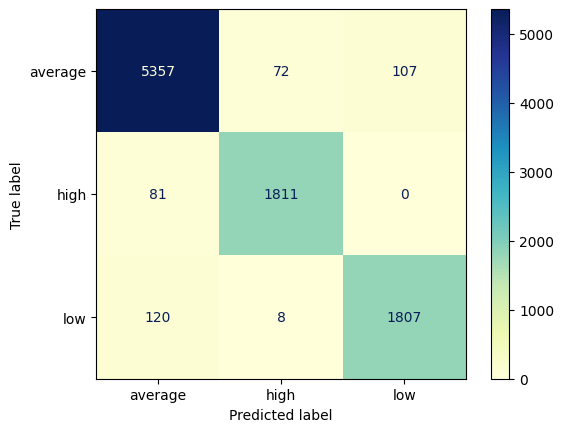

In [44]:
knn_class = KNeighborsClassifier()

class_model(knn_class, 'KNN Classifier')

- The KNN model scored almost as high as our Random Forest and Bagging trials, but also has the least variance of the three.
- Due to the high scores and low variance, KNN is a strong contender to be selected as our final model.

##### Multinomial Naive Bayes

Multinomial NB Classifier Training Score: 0.73282
Multinomial NB Classifier Testing Score: 0.73726 

Accuracy Rate: 0.83787
Misclassification Rate: 0.16213
Specificity Rate: 0.8682
Precision Rate: 0.58779
Recall Rate: 0.72145
F1 Score: 0.6478
Multinomial NB Classifier confusion matrix:


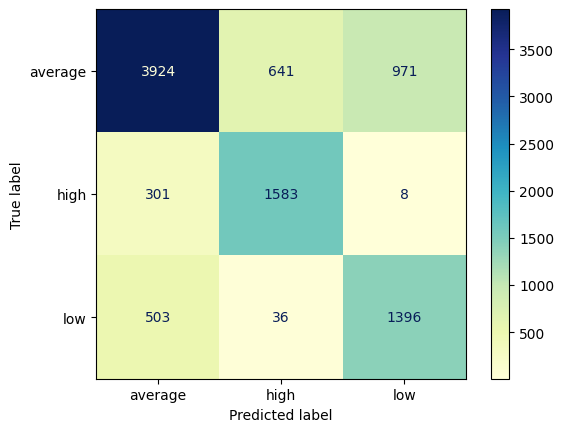

In [45]:
mnb_class = MultinomialNB()

class_model(mnb_class, 'Multinomial NB Classifier')

- Our MNB model did slightly better than the Ada Boost model, but still fell short of our 0.85 accuracy goal. 
- We will not be moving forward with MNB for our production model.

In [46]:
class_models_eval.sort_values(by='accuracy', ascending=False)

,model_used,train_score,test_score,accuracy,f1_score,precision,recall,specificity
2,Random Forest Classifier,1.000000,0.964434,0.978319,0.946621,0.963597,0.930233,0.990845
3,Bagging Classifier,0.996902,0.963687,0.978105,0.946124,0.962567,0.930233,0.990576
6,KNN Classifier,0.977142,0.958560,0.974901,0.938945,0.944096,0.933850,0.985595
1,Decision Tree Classifier,1.000000,0.958667,0.974581,0.938150,0.943544,0.932817,0.985460
4,Gradient Boosting Classifier,0.880937,0.876428,0.931005,0.810000,0.939932,0.711628,0.988153
0,Logistic Regression,0.804209,0.799744,0.875681,0.690426,0.711233,0.670801,0.929052
7,Multinomial NB Classifier,0.732821,0.737264,0.837872,0.647796,0.587789,0.721447,0.868201
5,Ada Boost Classifier,0.703340,0.710990,0.816832,0.453648,0.591362,0.367959,0.933764


In [47]:
class_models_eval['overfitness'] = class_models_eval['train_score'] - class_models_eval['test_score']
class_models_eval.sort_values(by='overfitness')

,model_used,train_score,test_score,accuracy,f1_score,precision,recall,specificity,overfitness
5,Ada Boost Classifier,0.703340,0.710990,0.816832,0.453648,0.591362,0.367959,0.933764,-0.007650
7,Multinomial NB Classifier,0.732821,0.737264,0.837872,0.647796,0.587789,0.721447,0.868201,-0.004443
0,Logistic Regression,0.804209,0.799744,0.875681,0.690426,0.711233,0.670801,0.929052,0.004465
4,Gradient Boosting Classifier,0.880937,0.876428,0.931005,0.810000,0.939932,0.711628,0.988153,0.004509
6,KNN Classifier,0.977142,0.958560,0.974901,0.938945,0.944096,0.933850,0.985595,0.018581
3,Bagging Classifier,0.996902,0.963687,0.978105,0.946124,0.962567,0.930233,0.990576,0.033216
2,Random Forest Classifier,1.000000,0.964434,0.978319,0.946621,0.963597,0.930233,0.990845,0.035566
1,Decision Tree Classifier,1.000000,0.958667,0.974581,0.938150,0.943544,0.932817,0.985460,0.041333


#### Classification Model Conclusions

All but two models met our 0.85 accuracy threshold (the mean accuracy score was 0.921), though the variance fluctuated greatly. 

The top-scoring models were, again, the Random Forest and Bagging classifiers. These two performed almost identically across various metrics, and both achieved accuracy scores of 0.978 (Random Forest edged out the Bagging model by just 0.000214). However, the Bagging model outperformed RF in one area - overfitness. Both models had moderate variance, but the gap between the train and test scores for the Bagging model was slightly smaller than that of RF.

Another frontrunner in our classification trials was the KNN Classifier, which scored 0.975 on accuracy and had even less variance than the Bagging Classifier. For this reason, we'd likely choose to move forward with our KNN model.
